In [1]:
import tensorflow as tf  
import numpy as np          
import argparse
import pandas as pd
from termcolor import colored


# 1 Read in data

In [2]:
# Blood ROSMAP
ROSMAPFrame = pd.read_csv("../../../Data/ROSMAP_blood_gene_expression_monocyte_ACTL_04172023.csv",header=0, index_col=0)
ROSMAPSampleID = list(ROSMAPFrame.columns.values)
ROSMAPGeneID = list(ROSMAPFrame.index.values)

# Blood ANMerge
ANMergeFrame = pd.read_csv("../../../Data/ADNI_blood_gene_expression_gene_aligned_04172023.csv",header=0, index_col=0)
ANMergeGeneID = list(ANMergeFrame.index.values)
ANMergeSampleID = list(ANMergeFrame.columns.values)

In [3]:
# log transform ROSMAP
ROSMAPFrame = np.log(ROSMAPFrame+1)

# gene overlap between ROSMAP and ANMerge
OverlapGene = list(set(ROSMAPGeneID) & set(ANMergeGeneID))
print("Number of overlapped gene is", colored(len(OverlapGene), 'red'))

Number of overlapped gene is 7704


## 1.1 Aligned dataframe to make their gene aligned

In [4]:
ROSMAPFrame = ROSMAPFrame.loc[OverlapGene,:]
ANMergeFrame = ANMergeFrame.loc[OverlapGene,:]

## 1.2 Read in labels

In [5]:
# read in label
ROSMAP_Info = pd.read_csv("../../../Data/ROSMAP_blood_clinical_monocyte_ACTL_04172023.csv",header=0, index_col=0)

# read in label
ANMerge_Info = pd.read_csv("../../../Data/ADNI_blood_clinical_04172023.csv",header=0, index_col=0)
    

In [6]:
import collections

ROSMAP_SID = list(ROSMAP_Info.loc[:,'specimenID'])
ROSMAP_Class = list(ROSMAP_Info.loc[:,'Group2'])
Mapping = {'Control': 0, 'Typical.AD': 1, 'Asym.AD': 2, 'LowNFT.AD': 3}
DigitClass = list()
for i in range(len(ROSMAP_SID)):
    tmp = Mapping[ROSMAP_Class[i]]
    DigitClass.append(tmp)


ANMerge_SID = list(ANMerge_Info.loc[:,'PTID'])
ANMerge_Class = list(ANMerge_Info.loc[:,'DX'])
Mapping = {'CN': 0, 'Dementia': 1, 'MCI': 2}
Mapping_SID_Class = {}
for i in range(len(ANMerge_SID)):
    Mapping_SID_Class[ANMerge_SID[i]] = ANMerge_Class[i]

# used in section 3.1
y_true = np.zeros(len(ANMergeSampleID))
for i in range(len(ANMergeSampleID)):
    y_true[i] = Mapping[Mapping_SID_Class[ANMergeSampleID[i]]]



# 2 Run MMD-MA

In [7]:
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics.pairwise import linear_kernel
import scipy as scip

## 2.1 compute  Gaussian Kernel 

In [8]:
# s is the parameter for the Gaussian kernel
s1 = 50
s2 = 30

# K1 is the Gaussian Kernel for ROSMAP
# XR should be an NxD matrix, where N is number of obs and D its features
XR = ROSMAPFrame.values.T
pairwise_sq_dists = squareform(pdist(XR, 'sqeuclidean'))
K1 = np.exp(-pairwise_sq_dists / s1**2)

# K2 is the Gaussian Kernel for ANMerge
# XR should be an NxD matrix, where N is number of obs and D its features
XA = ANMergeFrame.values.T
pairwise_sq_dists = squareform(pdist(XA, 'sqeuclidean'))
K2 = np.exp(-pairwise_sq_dists / s2**2)

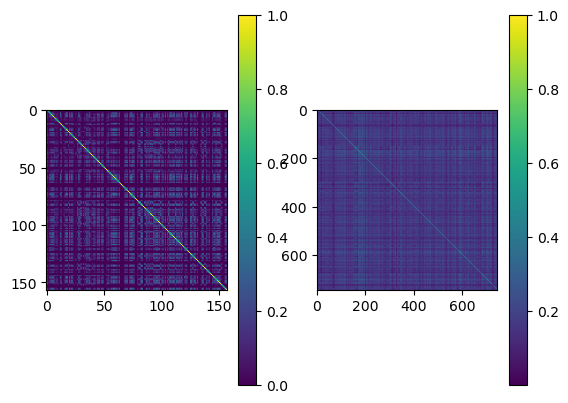

In [9]:
# draw the plot to better choose s1 and s2
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2)
im = ax[0].imshow(K1)
fig.colorbar(im,ax=ax[0])
im2 = ax[1].imshow(K2)
fig.colorbar(im2,ax=ax[1])

## 1.2 MMD-MA

In [10]:
def compute_pairwise_distances(x, y):
    """Computes the squared pairwise Euclidean distances between x and y.
  Args:
    x: a tensor of shape [num_x_samples, num_features]
    y: a tensor of shape [num_y_samples, num_features]
  Returns:
    a distance matrix of dimensions [num_x_samples, num_y_samples].
  Raises:
    ValueError: if the inputs do no matched the specified dimensions.
  """

    if not len(x.get_shape()) == len(y.get_shape()) == 2:
        raise ValueError('Both inputs should be matrices.')

    if x.get_shape().as_list()[1] != y.get_shape().as_list()[1]:
        raise ValueError('The number of features should be the same.')

    norm = lambda x: tf.reduce_sum(tf.square(x), 1)

  # By making the `inner' dimensions of the two matrices equal to 1 using
  # broadcasting then we are essentially substracting every pair of rows
  # of x and y.
  # x will be num_samples x num_features x 1,
  # and y will be 1 x num_features x num_samples (after broadcasting).
  # After the substraction we will get a
  # num_x_samples x num_features x num_y_samples matrix.
  # The resulting dist will be of shape num_y_samples x num_x_samples.
  # and thus we need to transpose it again.
    return tf.transpose(norm(tf.expand_dims(x, 2) - tf.transpose(y)))

def gaussian_kernel_matrix(x, y, sigmas):
    """Computes a Guassian Radial Basis Kernel between the samples of x and y.
  We create a sum of multiple gaussian kernels each having a width sigma_i.
  Args:
    x: a tensor of shape [num_samples, num_features]
    y: a tensor of shape [num_samples, num_features]
    sigmas: a tensor of floats which denote the widths of each of the
      gaussians in the kernel.
  Returns:
    A tensor of shape [num_samples{x}, num_samples{y}] with the RBF kernel.
  """
    beta = 1. / (2. * (tf.expand_dims(sigmas, 1)))
    dist = compute_pairwise_distances(x, y)
    s = tf.matmul(beta, tf.reshape(dist, (1, -1)))

    return tf.reshape(tf.reduce_sum(tf.exp(-s), 0), tf.shape(dist))

def maximum_mean_discrepancy(x, y, kernel=gaussian_kernel_matrix, bandwidth=1.0):
    """Computes the Maximum Mean Discrepancy (MMD) of two samples: x and y.
  Maximum Mean Discrepancy (MMD) is a distance-measure between the samples of
  the distributions of x and y. Here we use the kernel two sample estimate
  using the empirical mean of the two distributions.
  MMD^2(P, Q) = || \E{\phi(x)} - \E{\phi(y)} ||^2
              = \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) },
  where K = <\phi(x), \phi(y)>,
    is the desired kernel function, in this case a radial basis kernel.
  Args:
      x: a tensor of shape [num_samples, num_features]
      y: a tensor of shape [num_samples, num_features]
      kernel: a function which computes the kernel in MMD. Defaults to the
              GaussianKernelMatrix.
  Returns:
      a scalar denoting the squared maximum mean discrepancy loss.
  """
    with tf.name_scope('MaximumMeanDiscrepancy'):
        # \E{ K(x, x) } + \E{ K(y, y) } - 2 \E{ K(x, y) }
        cost = tf.reduce_mean(kernel(x, x, tf.constant([bandwidth])))
        cost += tf.reduce_mean(kernel(y, y, tf.constant([bandwidth])))
        cost -= 2 * tf.reduce_mean(kernel(x, y, tf.constant([bandwidth])))

        # We do not allow the loss to become negative.
        cost = tf.where(cost > 0, cost, 0, name='value')
    return cost

In [11]:
k1_matrix = K1
k2_matrix = K2
n1 = k1_matrix.shape[0]
n2 = k2_matrix.shape[0]
K1 = tf.constant(k1_matrix, dtype=tf.float32)
K2 = tf.constant(k2_matrix, dtype=tf.float32)

p = 10 # embeded dim 
k = 100 # random seed
training_rate = 0.00005
bandwidth = 1.0
tradeoff2 = 0.01
tradeoff3 = 0.001
I_p=tf.eye(p)

In [12]:
alpha = tf.Variable(tf.random.uniform([n1, p], minval=0.0, maxval=0.1, seed=k))
beta = tf.Variable(tf.random.uniform([n2, p], minval=0.0, maxval=0.1, seed=k))

optimizer = tf.keras.optimizers.Adam(learning_rate=training_rate)
objbest = 1e20
for i in range(10001):
    with tf.GradientTape() as tape:
        mmd_part = maximum_mean_discrepancy(tf.matmul(K1, alpha), tf.matmul(K2, beta), bandwidth=bandwidth)
        penalty_part = tradeoff2 * (tf.norm(tf.subtract(tf.matmul(tf.transpose(alpha), tf.matmul(K1, alpha)), I_p), ord=2) + tf.norm(tf.subtract(tf.matmul(tf.transpose(beta), tf.matmul(K2, beta)), I_p), ord=2))
        distortion_part = tradeoff3 * (tf.norm(tf.subtract(tf.matmul(tf.matmul(K1, alpha), tf.matmul(tf.transpose(alpha), tf.transpose(K1))), K1), ord=2) + tf.norm(tf.subtract(tf.matmul(tf.matmul(K2, beta), tf.matmul(tf.transpose(beta), tf.transpose(K2))), K2), ord=2))
        myFunction = mmd_part + penalty_part + distortion_part

    gradients = tape.gradient(myFunction, [alpha, beta])
    optimizer.apply_gradients(zip(gradients, [alpha, beta]))

    #if i % 100 == 0:
    if objbest > myFunction.numpy():
        objbest = myFunction.numpy()
        alpha_best = alpha.numpy()
        beta_best = beta.numpy()
        besti = i
        rec = '\t'.join([str(k), str(i), str(myFunction.numpy()), str(mmd_part.numpy()), str(penalty_part.numpy()), str(distortion_part.numpy())])
        print(rec)
        #record.write(rec + '\n')

np.savetxt("alpha_hat_" + str(k) + "_" + str(besti) + ".txt", alpha_best)
np.savetxt("beta_hat_" + str(k) + "_" + str(besti) + ".txt", beta_best)

100	0	333.41568	0.57604367	23.558062	309.2816
100	1	332.75424	0.57649064	23.511198	308.66656
100	2	332.09357	0.5769383	23.464384	308.05225
100	3	331.43353	0.5773867	23.417622	307.43854
100	4	330.77417	0.5778357	23.370905	306.82544
100	5	330.11563	0.5782855	23.32424	306.2131
100	6	329.4577	0.5787358	23.277624	305.60135
100	7	328.80057	0.5791869	23.231064	304.99033
100	8	328.14417	0.5796385	23.184555	304.37997
100	9	327.4885	0.58009076	23.1381	303.7703
100	10	326.83362	0.58054364	23.0917	303.16138
100	11	326.17947	0.5809972	23.045351	302.55313
100	12	325.52612	0.58145136	22.99906	301.94562
100	13	324.87363	0.5819061	22.952822	301.3389
100	14	324.22186	0.58236134	22.906643	300.73285
100	15	323.5709	0.58281726	22.860525	300.12756
100	16	322.9208	0.5832737	22.81446	299.52307
100	17	322.27148	0.5837306	22.768457	298.9193
100	18	321.62308	0.58418816	22.722511	298.31638
100	19	320.97546	0.5846462	22.676628	297.7142
100	20	320.32874	0.5851049	22.6308	297.11282
100	21	319.6828	0.58556396	22.5850

In [13]:
np.shape(alpha_best)

(157, 10)

In [14]:
np.shape(beta_best)

(744, 10)

# 3 UMAP Plot

In [15]:
import umap
import sklearn.datasets
import umap.plot

/Users/yijwang-admin/anaconda3/envs/tf/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/yijwang-admin/anaconda3/envs/tf/lib/python3.11/site-packages/umap/plot.py:203: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit(nopython=False)


In [16]:
# Umap need a matrix obs by features
Embed_Stack = np.vstack((alpha_best,beta_best))

# label
N_K1 = np.shape(alpha_best)[0]
Label = np.zeros(np.shape(Embed_Stack)[0])
Label[N_K1:] = 1

mapper = umap.UMAP().fit(Embed_Stack)

<Axes: >

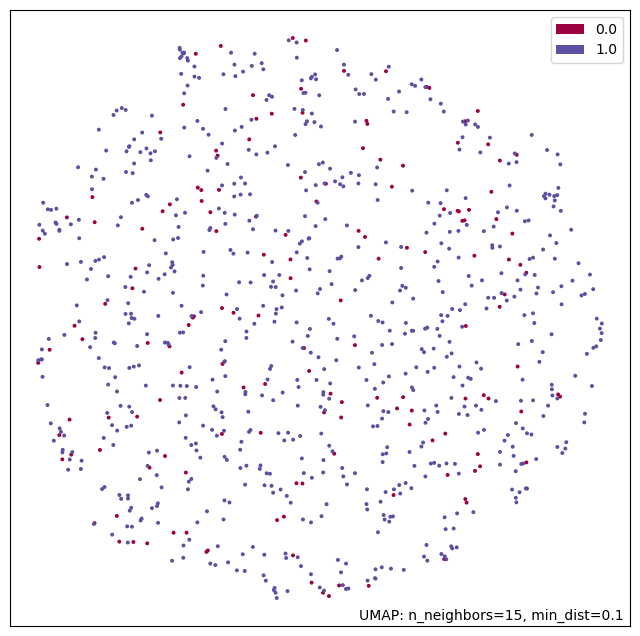

In [17]:
umap.plot.points(mapper, labels=Label)

## 3.1 KNN to transfer labels

In [18]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(alpha_best,DigitClass)

KNeighborsClassifier(n_neighbors=1)

In [19]:
y_pred = np.zeros(len(ANMergeSampleID))
y_pred = -1+y_pred

for i in range(len(ANMergeSampleID)):
    y_pred[i] = neigh.predict([beta_best[i,:]])

## 3.2 Evaulation

In [20]:
#Mapping = {'Control': 0, 'Typical.AD': 1, 'Asym.AD': 2, 'LowNFT.AD': 3}
#Mapping = {'CTL': 0, 'AD': 1, 'MCI': 2}


pred_ind_cn = np.where(y_pred==0)[0]
true_ind_cn = np.where(y_true==0)[0]
overlap = list(set(pred_ind_cn) & set(true_ind_cn))

pred_ind_aad = np.where(y_pred==2)[0]
true_ind_aad = np.where(y_true==2)[0]
overlap = list(set(pred_ind_aad) & set(true_ind_aad))

pred_ind_tad = np.where(y_pred==1)[0]
true_ind_tad = np.where(y_true==1)[0]
true_ind_tad_aad = list(true_ind_aad) + list(true_ind_tad)
overlap = list(set(pred_ind_tad) & set(true_ind_tad_aad))
print("precision of TAD is ", len(overlap)/len(pred_ind_tad))

pred_ind_aad_cn = list(pred_ind_aad) #+ list(pred_ind_cn)
true_ind_aad_cn = list(true_ind_cn) + list(true_ind_aad)
overlap = list(set(pred_ind_aad_cn) & set(true_ind_aad_cn))
print("precision of AAD  is ", len(overlap)/len(pred_ind_aad_cn))

pred_ind_aad_cn = list(pred_ind_cn) #list(pred_ind_aad) + 
true_ind_aad_cn = list(true_ind_cn) + list(true_ind_aad)
overlap = list(set(pred_ind_aad_cn) & set(true_ind_aad_cn))
if len(pred_ind_aad_cn) == 0:
    print("precision of CN  is 0")
else:
    print("precision of CN  is ", len(overlap)/len(pred_ind_aad_cn))

pred_ind_lt = np.where(y_pred==3)[0]
true_ind_lt = np.where(y_true==1)[0]
true_ind_lt_aad = list(true_ind_aad) + list(true_ind_lt)
overlap = list(set(pred_ind_lt) & set(true_ind_lt_aad))
if len(pred_ind_lt) == 0:
    print("precision of LowTau is 0")
else:
    print("precision of LowTau is ", len(overlap)/len(pred_ind_lt))


precision of TAD is  0.6859903381642513
precision of AAD  is  0.854679802955665
precision of CN  is  0.8584905660377359
precision of LowTau is  0.68
